In [36]:
import pandas as pd
import numpy as np
import datetime as dt

from tensorflow import keras
import tensorflow as tf
from keras.utils import timeseries_dataset_from_array

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

## Importación de datos

Leemos el archivo y ordenamos por datetime

In [37]:
data_df = pd.read_csv('data_training/predictores_modelo_pasado.csv')
data_df['Datetime_hour'] = pd.to_datetime(data_df['Datetime_hour'])
data_df['day_of_week'] = data_df['Datetime_hour'].dt.dayofweek
data_df = data_df.sort_values(by=['Datetime_hour']).reset_index(drop=True)
data_df

,Datetime_hour,Gen.P48 Fotovoltaica,MD,IDA1,IDA2,Gen.P48 Eolica,Interconexiones P48,Demanda P48,Gen.P48 Total,Hour,Month,Day_of_week,Precio_Gas,Precio_CO2_lag24,day_of_week
0,2024-01-02 23:00:00,3.1,6.80,8.35,18.79,14988.7,-126.0,24219.7,28251.0,0,1,2,30.75,73.17,1
1,2024-01-03 00:00:00,6.7,3.20,3.20,6.44,14374.7,-344.6,22525.0,27296.5,1,1,2,30.75,73.17,2
2,2024-01-03 01:00:00,19.4,3.20,3.20,3.20,14194.0,-1026.3,21433.4,27085.6,2,1,2,30.75,73.17,2
3,2024-01-03 02:00:00,2.2,3.20,3.20,3.20,13560.5,-716.5,20927.5,26314.0,3,1,2,30.75,73.17,2
4,2024-01-03 03:00:00,18.7,3.20,3.20,3.20,13483.0,-1122.9,20736.7,26229.6,4,1,2,30.75,73.17,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13819,2025-07-31 18:00:00,3933.6,107.99,119.91,122.38,9624.1,-2968.9,32146.3,35130.0,20,7,3,34.48,72.17,3
13820,2025-07-31 19:00:00,309.7,114.45,111.45,111.65,11052.2,-1356.7,32179.0,34616.8,21,7,3,34.48,72.17,3
13821,2025-07-31 20:00:00,0.3,110.27,109.22,110.22,12185.9,-2681.6,31008.0,35120.6,22,7,3,34.48,72.17,3
13822,2025-07-31 21:00:00,0.3,98.32,98.52,102.78,12407.5,-3586.2,28579.2,33451.4,23,7,3,34.48,72.17,3


### Visualización inicial

Visualizamos la forma de la función target para las últimas 2 semanas

In [38]:
px.line(data_df.iloc[-3*24*7:], x='Datetime_hour', y='MD')

## Parte 1 - Modelo con 24 outputs

### Preparacion datos

In [92]:
def create_sequences(df, input_steps, output_steps, target_column):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps, :])  # Ventana de entrada
        y.append(data[i+input_steps:i+input_steps+output_steps, target_idx])  # Ventana de salida

    return np.array(X), np.array(y)

In [93]:
### PARAMETROS
fecha_inicio = '2024-01-01'
cols_to_drop = ['IDA1', 'IDA2']

val_days = 14
test_days = 14
features = [col for col in data_df.columns if col not in ['Datetime_hour']]

input_steps = 24*3
output_steps = 24

batch_size = 32

In [94]:
# Seleccionar valores
data_df = data_df.loc[data_df['Datetime_hour'] >= fecha_inicio]
data_df_clean = data_df.drop(columns=cols_to_drop)


# Número de muestras
num_test_samples = test_days * 24
num_val_samples = val_days * 24
num_train_samples = len(data_df_clean) - num_val_samples - num_test_samples
# Division en train, val y test
data_df_input = data_df_clean.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences(train_df, input_steps, output_steps, 'MD')
X_val, y_val = create_sequences(val_df, input_steps, output_steps, 'MD')
X_test, y_test = create_sequences(test_df, input_steps, output_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (4320, 72, 12), Val: (241, 72, 12), Test: (241, 72, 12)
Train: (4320, 24), Val: (241, 24), Test: (241, 24)


C:\Users\jnavarro\AppData\Local\Temp\ipykernel_34872\37368772.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.51732449 -1.37284701 -1.22836952 ...  1.51670273  1.66118022
 -1.66180198]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_34872\37368772.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46402873 -1.46402873 -1.46402873 ...  1.95832576  1.95832576
  1.95832576]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_34872\37368772.py:22: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.49962397 -0.49962397 -0.49962397 ...  0.00284524  0.00284524
  0.50531445]' has dtype incompatib

### Modelo LSTM

In [ ]:
### PARAMETROS
dropout = 0.2
n_neurons = 128
r_drop = 0.25
patience = 8
lr = 0.0005
n_epochs = 100
regularizer = keras.regularizers.l2(1e-4)

In [ ]:
inputs = keras.Input(shape=(input_steps, data_array.shape[-1]))
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=True, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
x = keras.layers.LSTM(n_neurons, recurrent_dropout=r_drop, activation='tanh', return_sequences=False, kernel_regularizer=regularizer)(inputs)
x = keras.layers.Dropout(dropout)(x)
outputs = keras.layers.Dense(output_steps)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
]

optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks)

Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.5101 - mae: 0.5686 - val_loss: 0.3052 - val_mae: 0.4483
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.3153 - mae: 0.4274 - val_loss: 0.2525 - val_mae: 0.3924
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.2632 - mae: 0.3889 - val_loss: 0.2330 - val_mae: 0.3681
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.2345 - mae: 0.3665 - val_loss: 0.2130 - val_mae: 0.3465
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.2145 - mae: 0.3503 - val_loss: 0.2284 - val_mae: 0.3596
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1997 - mae: 0.3378 - val_loss: 0.2458 - val_mae: 0.3711
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1882 - mae: 0.3273 - val_loss: 0.2317 - val_mae: 0.3527
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.1780 - mae: 0.3175 - val_loss: 0.2291 - val_mae: 0.3540
Epoch 9/100
135/135 ━━━━━━━━━━━━━━━━━━━━

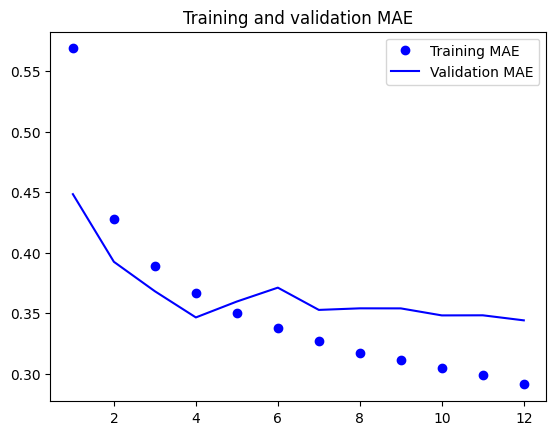

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Evaluación y resultados

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
y_pred = model.predict(X_test)

y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test)


rmse = np.sqrt(mean_squared_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten()))
mae  = mean_absolute_error(y_test_rescaled.flatten(), y_pred_rescaled.flatten())

print(f"RMSE: {rmse:.3f}")
print(f"MAE : {mae:.3f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
RMSE: 26.266
MAE : 20.628


## Parte 2: 1 output step y forecast iterativo

### Preparación de datos

In [79]:
def create_sequences_single_step(df, input_steps, target_column, step=1):
    X, y = [], []
    data = df.values
    target_idx = df.columns.get_loc(target_column)

    for i in range(0, len(df) - input_steps, step):
        X.append(data[i:i+input_steps, :])             # Ventana de entrada
        y.append(data[i+input_steps, target_idx])      # Solo 1 paso hacia adelante

    return np.array(X), np.array(y).reshape(-1, 1)

In [84]:
output_steps = 1

# Seleccionar valores
data_df = data_df.loc[data_df['Datetime_hour'] >= fecha_inicio]
data_df_clean = data_df.drop(columns=cols_to_drop)


# Número de muestras
num_test_samples = test_days * 24
num_val_samples = val_days * 24
num_train_samples = len(data_df_clean) - num_val_samples - num_test_samples
# Division en train, val y test
data_df_input = data_df_clean.drop(columns=['Datetime_hour'])
train_df = data_df_input.iloc[:num_train_samples].copy()
val_df = data_df_input.iloc[num_train_samples:num_train_samples + num_val_samples].copy()
test_df = data_df_input.iloc[num_train_samples + num_val_samples:].copy()



# Escalado de features (X)
predictors = [col for col in train_df.columns if col not in ['MD', 'Datetime_hour']]
x_scaler = StandardScaler()

train_df.loc[:, predictors] = x_scaler.fit_transform(train_df[predictors])
val_df.loc[:, predictors]   = x_scaler.transform(val_df[predictors])
test_df.loc[:, predictors]  = x_scaler.transform(test_df[predictors])


# Escalado de target (y)
y_scaler = StandardScaler()

train_df.loc[:, 'MD'] = y_scaler.fit_transform(train_df[['MD']])
val_df.loc[:, 'MD']   = y_scaler.transform(val_df[['MD']])
test_df.loc[:, 'MD']  = y_scaler.transform(test_df[['MD']])


# Ventanas temporales
X_train, y_train = create_sequences_single_step(train_df, input_steps, 'MD')
X_val, y_val = create_sequences_single_step(val_df, input_steps, 'MD')
X_test, y_test = create_sequences_single_step(test_df, input_steps, 'MD')

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")
print(f"Train: {y_train.shape}, Val: {y_val.shape}, Test: {y_test.shape}")

Train: (4343, 72, 12), Val: (264, 72, 12), Test: (264, 72, 12)
Train: (4343, 1), Val: (264, 1), Test: (264, 1)


C:\Users\jnavarro\AppData\Local\Temp\ipykernel_34872\3837597256.py:24: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.51732449 -1.37284701 -1.22836952 ...  1.51670273  1.66118022
 -1.66180198]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_34872\3837597256.py:24: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46402873 -1.46402873 -1.46402873 ...  1.95832576  1.95832576
  1.95832576]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

C:\Users\jnavarro\AppData\Local\Temp\ipykernel_34872\3837597256.py:24: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.49962397 -0.49962397 -0.49962397 ...  0.00284524  0.00284524
  0.50531445]' has dtype inco

## Calculo del error base

Tenemos que establecer un objetivo de precisión para nuestro modelo. Para ello, suponemos dos pronósticos iniciales:
1. El precio a la misma hora del día anterior
2. El precio a la misma hora y el mismo día de la semana anterior

Consideramos esta segunda posibilidad, debido a la gran diferencia que existe entre los precios en fin de semana y entre semana.

In [104]:
md_true = []
md_delay_day = []
data_array = data_df_input.values

# Calculamos los targets para el dataset sin escalar
for i in range(len(data_array) - input_steps - output_steps):
    md_true.append(data_array[i+input_steps:i+input_steps+output_steps, features.index('MD')])
    # Delay de 1 dia
    md_delay_day.append(data_array[i+input_steps-24:i+input_steps+output_steps-24, features.index('MD')])


md_true = np.array(md_true)
md_delay_day = np.array(md_delay_day)

print(f"MAE day-delay: {np.mean(np.abs(md_true - md_delay_day))}")

MAE day-delay: 19.62972358578775


Evolución del entrenamiento

In [99]:
y_pred_rescaled.shape

(923, 24)